In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandapower as pp
import pandas as pd
from pandapower.networks import case33bw
from pandapower.plotting import simple_plot
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandapower.timeseries as timeseries
from pandapower.timeseries.data_sources.frame_data import DFData
import pandapower.control as control
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [3]:
data_path = Path("./in/pv_in.csv").resolve()
pv_data = pd.read_csv(data_path)

In [4]:
net = case33bw()

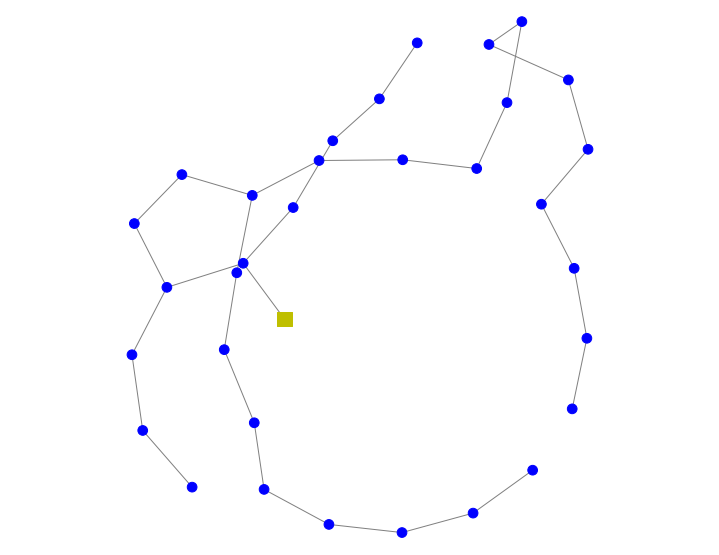

<AxesSubplot:>

In [5]:
simple_plot(net)

In [6]:
print(net)

This pandapower network includes the following parameter tables:
   - bus (33 elements)
   - load (32 elements)
   - ext_grid (1 element)
   - line (37 elements)
   - poly_cost (1 element)
   - bus_geodata (33 elements)


In [7]:
# Add 600 kW of generation to 6 of the buses
pv_buses = [5, 11, 17, 24, 30, 32]
for bus in pv_buses:
    pp.create_gen(net, bus, p_mw=0.6)

<AxesSubplot:>

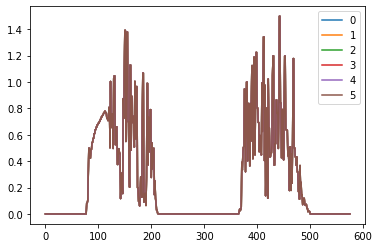

In [17]:
pv_data.plot()

In [8]:
pv_data.columns = net.gen.index
# Randomly perturb the load, not realistic just testing whether the solar 
random_load = pd.DataFrame(np.random.normal(0.8, 0.1, size=(len(pv_data), len(net.load.index))),
                  index=list(range(len(pv_data))), columns=net.load.index)
load_ds = DFData(random_load)
ds = DFData(pv_data)

const_gen = control.ConstControl(
    net,
    element="gen",
    element_index=net.gen.index,
    variable="scaling",
    data_source=ds,
    profile_name=net.gen.index,
)
const_load = control.ConstControl(
    net,
    element="load",
    element_index=net.load.index,
    variable="scaling",
    data_source=load_ds,
    profile_name=net.load.index,
)

In [9]:
ow = timeseries.OutputWriter(net, output_path="./out", output_file_type=".csv")
ow.log_variable("res_bus", "vm_pu")
ow.log_variable("res_gen", "p_mw")
ow.log_variable("res_load", "p_mw")
ow.log_variable("res_line", "loading_percent")

In [10]:
timeseries.run_timeseries(net, recycle=False)

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps


Progress: |██████████████████████████████████████████████████| 100.0% Complete



In [11]:
def plot_element(stat_name, element_type, elements, ymin, ymax):
    res_path = Path(f"./out/res_{element_type}/{stat_name}.csv").resolve()
    names = ["index", *net[element_type].index]
    df = pd.read_csv(res_path, sep=";", names=names, header=0)
    fig, ax = plt.subplots(len(elements), figsize=(10, 15))
    for i in range(len(elements)):
        sns.lineplot(ax=ax[i], x=df.index, y=df[elements[i]], data=df)
        ax[i].set_title(f"{element_type} {elements[i]}")
        ax[i].set_yticks(np.linspace(ymin, ymax, 10))
        ax[i].yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
    fig.tight_layout()
    plt.show()

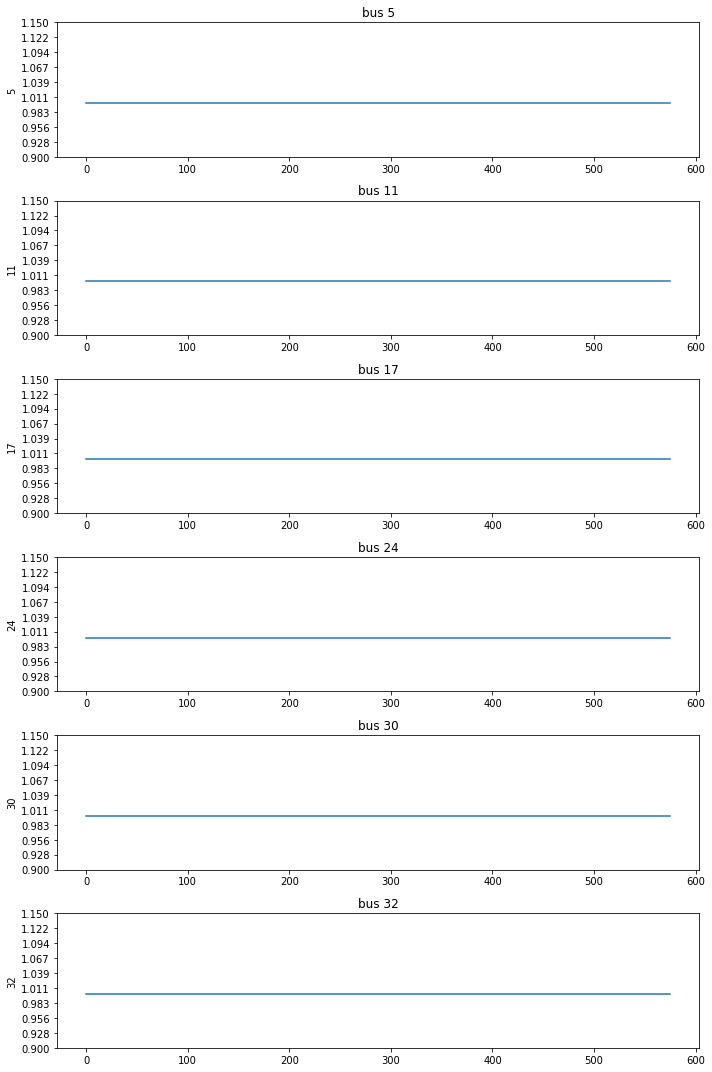

In [12]:
plot_element("vm_pu", "bus", pv_buses, 0.90, 1.15)

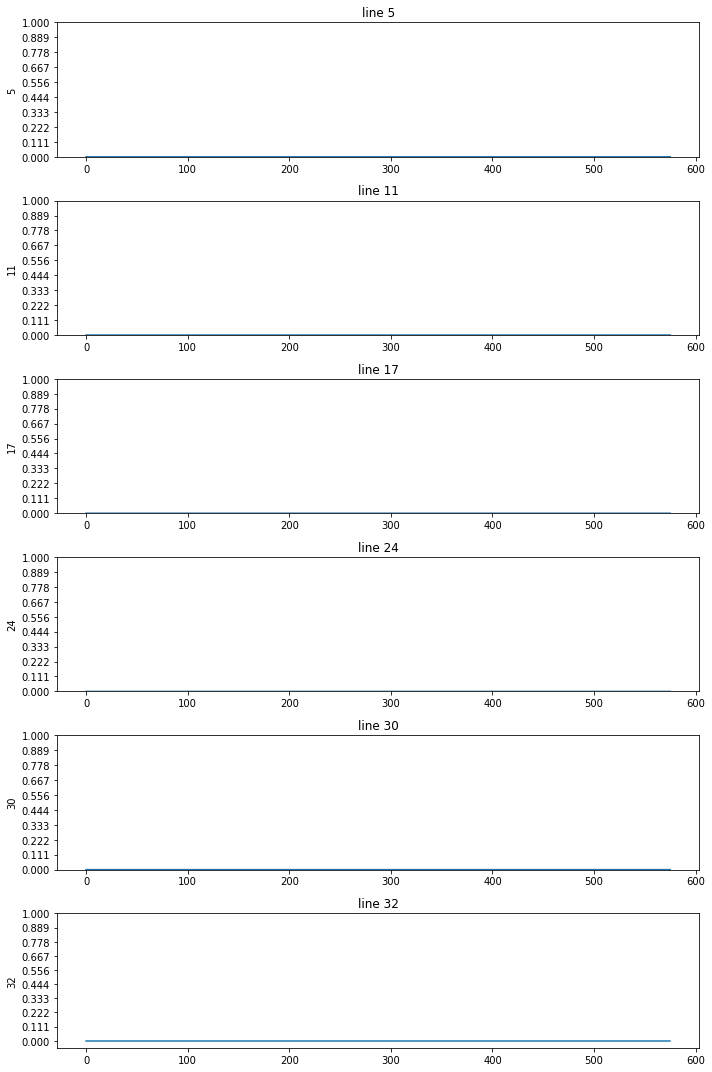

In [13]:
plot_element("loading_percent", "line", pv_buses, 0.0, 1.0)

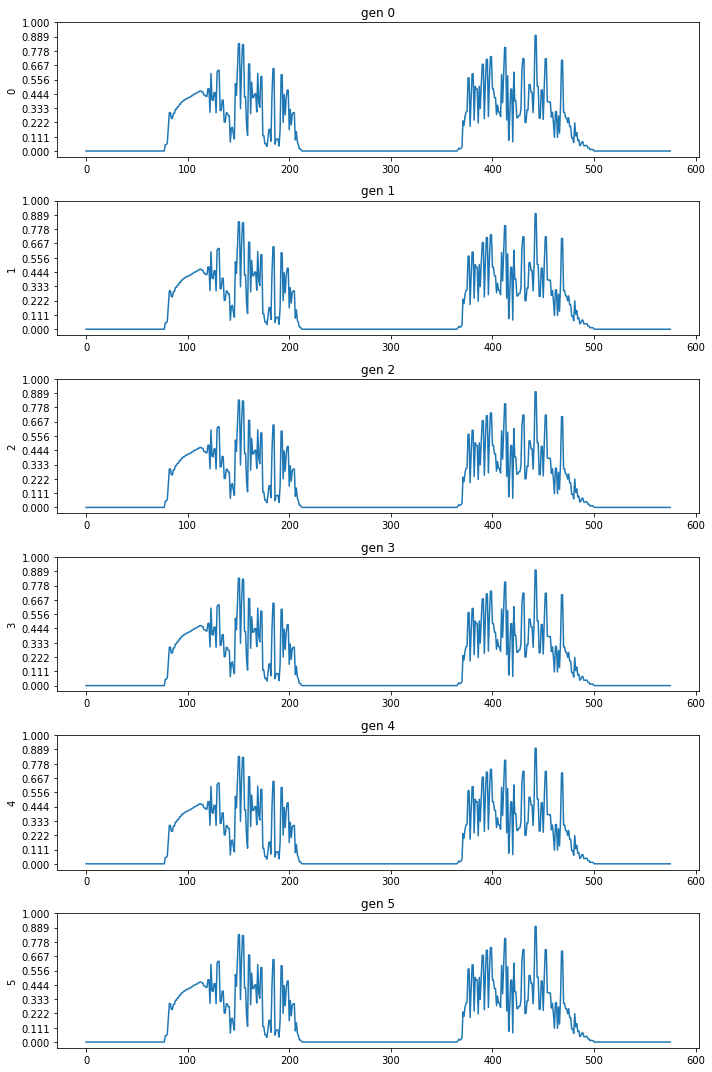

In [14]:
plot_element("p_mw", "gen", net.gen.index, 0, 1)

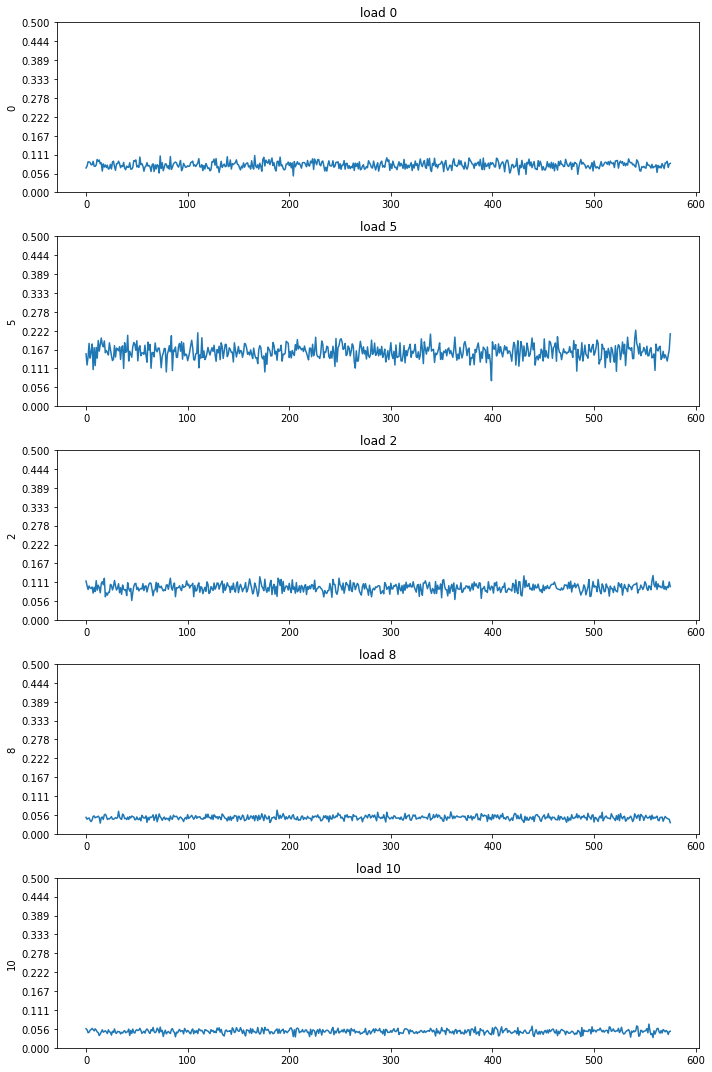

In [15]:
plot_element("p_mw", "load", [0, 5, 2, 8, 10], 0, 0.5)